## Putting it all together

In [1]:
import seaborn as sns; sns.set_style("dark")
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler, Normalizer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import janitor
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNetCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.feature_selection import RFECV

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,806407308,Attrited Customer,54,F,3,College,Single,Unknown,Blue,49,...,2,3,13184.0,0,13184.0,1.166,2047,33,0.179,0.000
1,801786483,Existing Customer,51,M,0,High School,Single,$80K - $120K,Blue,45,...,2,3,10648.0,2517,8131.0,0.708,4930,89,0.978,0.236
2,779870883,Existing Customer,45,F,4,High School,Single,$40K - $60K,Blue,29,...,2,1,4595.0,1781,2814.0,0.708,3746,68,0.545,0.388
3,720336708,Existing Customer,53,M,3,Doctorate,Married,$40K - $60K,Blue,35,...,3,2,3789.0,1706,2083.0,1.047,1609,42,0.680,0.450
4,716769783,Existing Customer,48,F,2,Graduate,Married,Unknown,Blue,40,...,2,4,5104.0,736,4368.0,0.679,3943,78,0.696,0.144


In [4]:
test.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,720943308,Existing Customer,47,M,3,Graduate,Single,$60K - $80K,Silver,36,...,1,2,30498.0,1990,28508.0,0.839,16202,120,0.791,0.065
1,710879283,Existing Customer,51,M,1,High School,Married,Less than $40K,Blue,41,...,4,3,1438.3,0,1438.3,0.623,4312,81,0.723,0.000
2,787800108,Existing Customer,55,M,2,College,Married,$80K - $120K,Blue,45,...,1,2,2929.0,2431,498.0,1.632,1903,39,0.625,0.830
3,789200208,Existing Customer,40,F,4,Uneducated,Married,Unknown,Blue,29,...,3,3,3326.0,2181,1145.0,0.827,13583,110,0.746,0.656
4,711332883,Attrited Customer,62,M,1,High School,Single,$60K - $80K,Blue,46,...,3,3,7547.0,2477,5070.0,1.021,5294,73,0.698,0.328


In [5]:
train, val = train_test_split(train, random_state = 42, train_size = 0.8, stratify = train["attrition_flag"])

### Hardcoded Feature Engineering

In [6]:
train["revolving_trans"] = train["total_revolving_bal"]/train["total_trans_amt"]
val["revolving_trans"] = val["total_revolving_bal"]/val["total_trans_amt"]
test["revolving_trans"] = test["total_revolving_bal"]/test["total_trans_amt"]

In [7]:
train["marriage_education"] = train["marital_status"] + "_" + train["education_level"]
val["marriage_education"] = val["marital_status"] + "_" + val["education_level"]
test["marriage_education"] = test["marital_status"] + "_" + test["education_level"]

In [8]:
train["attrition_flag"] = train["attrition_flag"].replace(["Attrited Customer","Existing Customer"], [1,0]).astype(int)
test["attrition_flag"] = test["attrition_flag"].replace(["Attrited Customer","Existing Customer"], [1,0]).astype(int)
val["attrition_flag"] = val["attrition_flag"].replace(["Attrited Customer","Existing Customer"], [1,0]).astype(int)

### Splitting into independent and dependent variables

In [9]:
x_train, y_train = train.drop(['attrition_flag','clientnum'], axis = 1), train["attrition_flag"]

In [10]:
x_val, y_val = val.drop(['attrition_flag','clientnum'], axis = 1), val["attrition_flag"]

In [11]:
x_test, y_test = test.drop(['attrition_flag','clientnum'], axis = 1), test["attrition_flag"]

### Gathering categorical and numerical columns

In [12]:
num = []
cat = []
columns = list(x_train.columns)
for col in columns:
    if is_numeric_dtype(x_train[col]):
        num.append(col)
    elif is_string_dtype(x_train[col]):
        cat.append(col)

### Preprocessing tools

In [13]:
one_hot = OneHotEncoder()
min_max = MinMaxScaler()
sd = StandardScaler()
le = LabelEncoder()

In [14]:
ct = ColumnTransformer([("one_hot", one_hot, cat), ("min_max", min_max, num)])

### Pipeline Creation

In [15]:
pipeline = Pipeline([("ct", ct), ("rfe", RFECV(Lasso())), ("nb", GaussianNB())])

### Fitting pipeline on training data

In [16]:
model = pipeline.fit(x_train, y_train)

### Evaluating pipeline's accuracy

#### Training data results

In [17]:
pred_train = model.predict(x_train)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      5439
           1       0.31      0.03      0.05      1041

    accuracy                           0.83      6480
   macro avg       0.58      0.51      0.48      6480
weighted avg       0.76      0.83      0.77      6480



<AxesSubplot:>

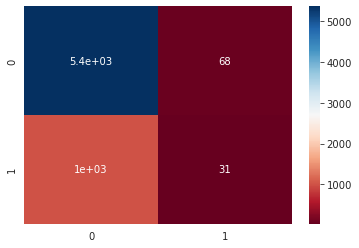

In [18]:
conf = confusion_matrix(y_train, pred_train)
sns.heatmap(conf, annot = True, cmap = "RdBu")

In [19]:
train["prediction"] = pred_train
train_probs = model.predict_proba(x_train)
train["prob_0"], train["prob_1"] = train_probs[:,0], train_probs[:,1]
train.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,revolving_trans,marriage_education,prediction,prob_0,prob_1
6694,716389833,0,50,F,1,Unknown,Single,Less than $40K,Blue,40,...,0.521,4099,74,0.721,0.442,0.250305,Single_Unknown,0,0.869164,0.130836
6698,787430733,0,56,F,2,High School,Married,$40K - $60K,Blue,41,...,0.686,1706,27,0.227,0.522,0.847597,Married_High School,0,0.865010,0.134990
5560,719539458,0,46,F,3,Graduate,Single,Less than $40K,Blue,41,...,0.722,5170,93,0.860,0.000,0.000000,Single_Graduate,0,0.832729,0.167271
2893,716791908,0,43,M,1,College,Married,$80K - $120K,Blue,23,...,0.417,4480,77,0.791,0.072,0.233259,Married_College,0,0.867568,0.132432
796,709562358,0,55,F,2,Unknown,Single,Less than $40K,Blue,43,...,0.973,4456,79,0.837,0.298,0.357720,Single_Unknown,0,0.876792,0.123208


#### Validation Data results

In [20]:
pred_val = model.predict(x_val)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1360
           1       0.32      0.03      0.06       261

    accuracy                           0.83      1621
   macro avg       0.58      0.51      0.49      1621
weighted avg       0.76      0.83      0.77      1621



<AxesSubplot:>

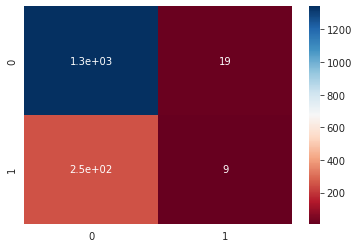

In [21]:
conf = confusion_matrix(y_val, pred_val)
sns.heatmap(conf, annot = True, cmap = "RdBu")

In [22]:
val["prediction"] = pred_val
val_probs = model.predict_proba(x_val)
val["prob_0"], val["prob_1"] = val_probs[:,0], val_probs[:,1]
val.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,revolving_trans,marriage_education,prediction,prob_0,prob_1
5423,788916933,0,49,M,5,College,Married,$60K - $80K,Gold,35,...,0.796,8095,81,0.620,0.031,0.131439,Married_College,0,0.855566,0.144434
4059,711452583,0,43,F,4,Graduate,Unknown,Unknown,Blue,36,...,0.796,4575,60,0.714,0.906,0.550164,Unknown_Graduate,0,0.881124,0.118876
1076,710780883,0,48,F,5,Uneducated,Single,$40K - $60K,Blue,38,...,0.860,4610,78,0.773,0.597,0.316920,Single_Uneducated,0,0.874369,0.125631
1295,719326758,1,52,F,0,Doctorate,Married,Less than $40K,Blue,36,...,0.945,9226,85,1.073,0.342,0.161392,Married_Doctorate,0,0.859560,0.140440
4485,708907833,0,38,F,1,High School,Single,Unknown,Blue,27,...,0.851,7866,84,0.909,0.101,0.319985,Single_High School,0,0.874570,0.125430


#### Test data results

In [23]:
pred_test = model.predict(x_test)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1701
           1       0.17      0.02      0.03       325

    accuracy                           0.83      2026
   macro avg       0.50      0.50      0.47      2026
weighted avg       0.73      0.83      0.77      2026



<AxesSubplot:>

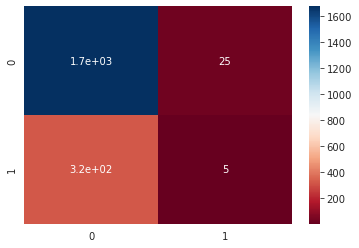

In [24]:
conf = confusion_matrix(y_test, pred_test)
sns.heatmap(conf, annot = True, cmap = "RdBu")

In [25]:
test["prediction"] = pred_test
test_probs = model.predict_proba(x_test)
test["prob_0"], test["prob_1"] = test_probs[:,0], test_probs[:,1]
test.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,revolving_trans,marriage_education,prediction,prob_0,prob_1
0,720943308,0,47,M,3,Graduate,Single,$60K - $80K,Silver,36,...,0.839,16202,120,0.791,0.065,0.122824,Single_Graduate,0,0.854341,0.145659
1,710879283,0,51,M,1,High School,Married,Less than $40K,Blue,41,...,0.623,4312,81,0.723,0.000,0.000000,Married_High School,0,0.832729,0.167271
2,787800108,0,55,M,2,College,Married,$80K - $120K,Blue,45,...,1.632,1903,39,0.625,0.830,1.277457,Married_College,0,0.768486,0.231514
3,789200208,0,40,F,4,Uneducated,Married,Unknown,Blue,29,...,0.827,13583,110,0.746,0.656,0.160568,Married_Uneducated,0,0.859456,0.140544
4,711332883,1,62,M,1,High School,Single,$60K - $80K,Blue,46,...,1.021,5294,73,0.698,0.328,0.467888,Single_High School,0,0.880658,0.119342
